In [50]:
import numpy as np
import pandas as pd
from scipy import optimize
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca
from sklearn import linear_model

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [2]:
# Path to your Excel file
SOURCE_DATA_SF3 = 'SupplementaryFigure3.xlsx'

# Read specific sheet and ranges
mf = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='A:HY', skiprows=2, nrows=502)
pc = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='HZ:TP', skiprows=2, nrows=502)

In [3]:
# rate is ssc0, drate is wv0
lm_MF = {
    'rate': mf.iloc[:, 0:116].to_numpy().T,
    'drate': mf.iloc[:, 116:232].to_numpy().T,
    'v0': mf.iloc[0, 232],
    'label': 'MF'
}

lm_PC = {
    'rate': pc.iloc[:, 0:151].to_numpy().T,
    'drate': pc.iloc[:, 151:302].to_numpy().T,
    'v0': pc.iloc[0, 302],
    'label': 'PC'
}

# for analyze data
data_mf = lm_MF['rate']
data_pc = lm_PC['rate']

In [4]:
#For FN PCA

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm = apca.smoothing_data()

In [20]:
# preprocessing

data_fn = np.array(np.concatenate(data_cat_sm, axis = 0))
pFN = data_fn[:,50:550]

pMP = data_mf[:, :500]
pPC = data_pc[:, :500]

pMPC = np.vstack((pMP, pPC))
pMPC = pMPC.T

In [85]:
betas = []
r_2 = []
for a in range(len(pFN)):
    pFN[a] = pFN[a] - np.mean(pFN[a][:100])
    beta, resid = np.linalg.lstsq(pMPC, pFN[a], rcond=None)[:2]
    resid = np.linalg.norm(pMPC @ beta - pFN[a])**2
    r_s = 1 - resid / (pFN[a].size * pFN[a].var())
    betas.append(beta)
    r_2.append(r_s)

betas = np.array(betas)
r_2 = np.array(r_2)

In [86]:
pFN[a].var()

np.float64(0.0015995684844979637)

In [88]:
resid

np.float64(6.424346588708254e-05)

(array([  1.,   2.,   6.,   5.,   4.,  20.,  31.,  37.,  85., 345.]),
 array([0.99784473, 0.99805928, 0.99827383, 0.99848838, 0.99870293,
        0.99891748, 0.99913202, 0.99934657, 0.99956112, 0.99977567,
        0.99999022]),
 <BarContainer object of 10 artists>)

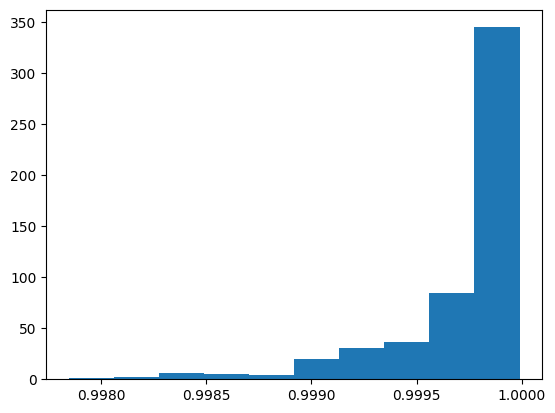

In [7]:
plt.hist(r_2)

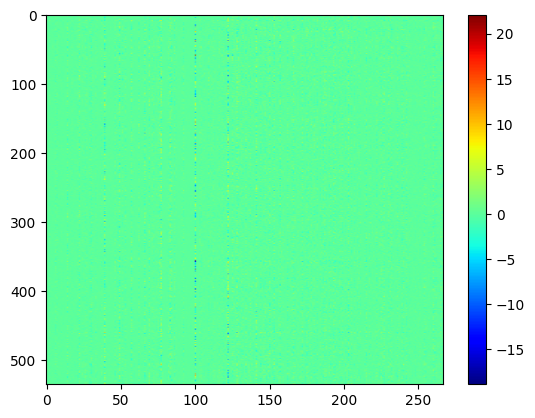

In [8]:
plt.imshow(betas, aspect='auto', cmap='jet', origin='upper')
plt.colorbar()

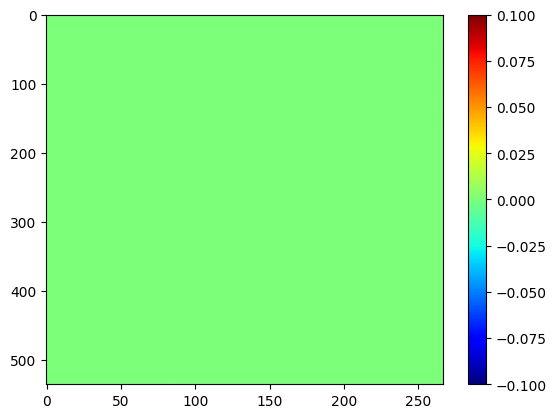

In [9]:
# Lasso
clf = linear_model.MultiTaskLasso()
clf.fit(pMPC, pFN.T)
plt.imshow(clf.coef_, aspect='auto', cmap='jet', origin='upper')
plt.colorbar()

In [93]:
# Make MF positive beta , PC beta negative

lower_bounds = np.concatenate([np.zeros(pMP.shape[0]), np.tile(-np.inf, pPC.shape[0])])
upper_bounds = np.concatenate([np.tile(np.inf, pMP.shape[0]), np.zeros(pPC.shape[0])])

betas_pn = []
r_2_pn = []
for a in range(len(pFN)):
    pFN[a] = pFN[a] - np.mean(pFN[a][:100])
    output = optimize.lsq_linear(pMPC, pFN[a], bounds=(lower_bounds, upper_bounds))
    beta = output['x']; resid = np.linalg.norm(output['fun'] ** 2)
    r_s = 1 - resid / (pFN[a].size * pFN[a].var())
    betas_pn.append(beta)
    r_2_pn.append(r_s)

betas_pn = np.array(betas_pn)
r_2_pn = np.array(r_2_pn)

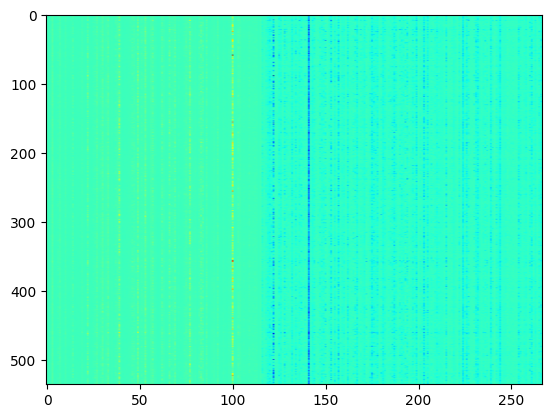

In [94]:
plt.imshow(betas_pn, aspect='auto', cmap='jet', origin='upper')

Text(0.5, 1.0, 'FN cell 1, R^2=0.9922838234163569')

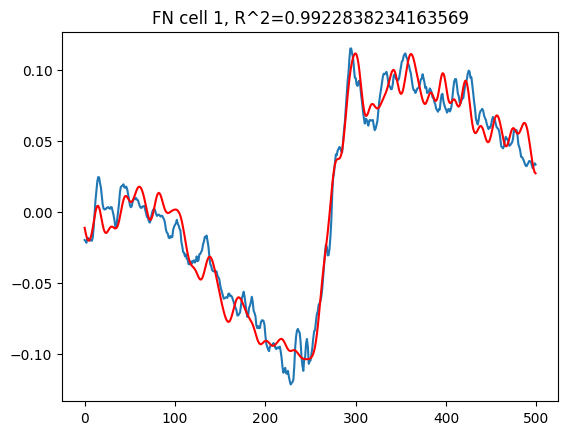

In [101]:
# plotting

a=0
plt.plot(pMPC @ betas_pn[a])
plt.plot(pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_s}')